In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import pickle

In [27]:
df = pd.read_excel('spalling.xlsx', index_col=0)

In [28]:
df_spall = df.loc[df['spalling']!=0]
df_spall = df_spall.loc[df['firecurve']=='std']
df_spall = df_spall.drop('firecurve', axis=1)
df_spall = df_spall.drop('weightloss', axis=1)
df_spall = df_spall.drop('time', axis=1)
df_spall = df_spall.drop('Age', axis=1)
df_use = df_spall

In [29]:
df_use.head()

,spalling,load,stress,moisture,Compressive strength
name,,,,,
1.1,20,624,6.24,4.5,63
1.4,21,617,6.17,4.5,63
1.5,17,634,6.34,4.5,63
2.1,32,622,6.22,4.1,61
2.4,19,616,6.16,4.1,61


In [30]:
X = df_use.drop('spalling', axis = 1)
y = df_use['spalling']

In [77]:
# X = X.to_numpy()
# y = y.to_numpy()

kf = KFold(n_splits=4,shuffle=True)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [78]:
LOWER_ALPHA = 0.1
MIDDLE_ALPHA = 0.5
UPPER_ALPHA = 0.9

In [79]:
lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls")
upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA)

In [80]:
# Fit models
lower_model.fit(X_train, y_train)
mid_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)
# Record actual values on test set
predictions = pd.DataFrame(y_test)
# Predict
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

In [81]:
predictions = pd.DataFrame(y_test)

In [82]:
predictions['upper'] = upper_model.predict(X_test)
X_test[:1]

array([[616, 6.16, 4.1, 61]], dtype=object)

In [83]:
d = {'y_test': y_test, 'predictions': predictions['upper']}
df_show = pd.DataFrame(data=d)

In [84]:
df_show

,y_test,predictions
0,19,31.923981
1,17,19.930112
2,15,25.204950
3,43,54.001835
4,44,44.284131
5,24,34.128806
6,40,41.694968
7,44,41.694968
8,36,31.016902
9,46,67.522165


In [91]:
df_show['under'] = df_show['predictions']>df_show['y_test']

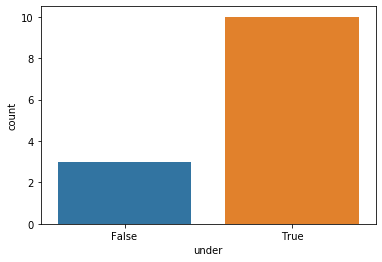

In [92]:
ax = sns.countplot(x="under", data=df_show)

In [87]:
d = {'load': [601], 'stress': [7], 'moisture': [5.9], 'Compressive strength': [60]}
d_test = pd.DataFrame(data=d)

print('Your slab will with a 90 percent certainty not spall more than: ')  
print(str(int(upper_model.predict(d_test))) + ' mm')

Your slab will with a 90 percent certainty not spall more than: 
56 mm


In [88]:
# r2_score(predictions['spalling'], predictions['upper'])

In [94]:
with open("regression_model.pickle", "wb") as file:
    pickle.dump(upper_model, file)
print ("Model saved.")

Model saved.
